## COG403: Problem 3 of Problem Set 2: Noun Classes in Tsez

### All 3 problems for Problem Set 2 Due 1 November 2018, 2 pm

In this problem, you'll implement a Naive Bayes classifier (we'll call this Model 0) as well as the Phonological Preference model (Model 3) from Gagliardi et al. (2012).  Then you'll apply Model 3 to three new sets of Tsez data: from younger children (4-7 year olds), older children (8-12 year olds), and adults, and analyze the pattern of learning revealed by the three.

### (a)

Implement `get_features_given_class` according to the docstring below.
This function computes the conditional probabilities $p(f_i|c_j)$
where $f_i$ is a feature value and $c_j$ is one of the noun classes. `get_features_given_class` will be used by both Model 0 and Model 3.

* For full credit on this problem, the `get_features_given_class` function should use an estimate of the expected value according to a Dirichlet distribution, as discussed in class, using the $\alpha$ as specified in the code prior to the function.

* For partial credit, you can use a Maximum Likelihood Estimate of the conditional probability in `get_features_given_class`.  You might also first implement the function using MLE in order to easily check your computations.

Make sure to go through and verify that your conditional probability computations make sense (ideally working them out by hand for a particular feature value). You are not required to show this here, but it is critical that you understand this to do well on this problem.

Call `get_feature_given_class('semantic')` to show the output of your function on semantic features.

In [11]:
import numpy as np
from data import class_features_joint, noun_class_probabilities


alpha = 0.001 # This is the alpha constant for the Dirichlet estimates
              # of expected values of the conditional probabilities.
              # (alpha_i = alpha_j for all feature values i, j)
# You're welcome to experiment with different values of alpha, but:
# BE SURE THAT alpha IS SET TO .001 FOR THE RESULTS YOU TURN IN.

# You may also find it useful to have a variable for alpha * n_feature_values
    
def get_feature_given_class(feature_type):
    """
    feature_type: string in {"beg_phonological", "semantic"}
    
    Return a np.array of shape (n_feature_values, n_classes), where each index is the conditional
    probability of a feature value of feature_type given one of the four noun classes.
    Make sure that the rows of the returned np.array correspond to the feature values in the order 
    specified by the values of the constants defined in data.py (e.g. SEMANTIC_ANIMATE is set to 0, 
    so it should be the 0th row).
    Similarly, make sure that the four classes correspond to the four columns.
    """
    probabilities = []
    for row in class_features_joint[feature_type]:
        feature_type_probabilities = []
        for column in row:
            k = alpha * len(row)
            feature_type_probabilities.append((column + alpha)/(noun_class_probabilities[row.index(column)]+(k/alpha)))
        probabilities.append(feature_type_probabilities)
    return np.array(probabilities)
get_feature_given_class('semantic')

array([[0.        , 0.        , 0.00011375, 0.        ],
       [0.        , 0.00018267, 0.        , 0.        ],
       [0.0005    , 0.        , 0.        , 0.        ],
       [0.        , 0.00043709, 0.00046571, 0.0005    ]])

### (b)

In the paper, Gagliardi et al. first present a Naive Bayes classifier as a baseline comparison to how children are classifying nouns in Tsez. Here, we will refer to this classifier as M0. Write a function `compute_trial_results_M0` that computes the results for each trial using equation (1) from the paper.

Call `compute_trial_results_M0` and print the result.

In [12]:
from data import features_by_trial


def compute_trial_results_M0():
    """
    Return a np.array of shape (n_trials, n_classes), where each row corresponds to
    a trial and each column corresponds to one of the four noun classes. 
    The rows
    should be a probability distribution over the four noun classes for each trial
    using a Naive Bayes Classifier that looks at phonological and semantic features
    (using formula (1) from Gagliardi et al.).
    """
    likelihood_terms = []
    beg_conditions = get_feature_given_class('beg_phonological')
    semantic_conditionals = get_feature_given_class('semantic')
    row = 0
    while row < len (features_by_trial['semantic']):
        denom = 0
        numerator = []
        beg_trial = features_by_trial['beg_phonological'][row]
        semantic_trial = features_by_trial['semantic'][row]
        for column in range(len(noun_class_probabilities)):
            total_prob = beg_conditions[beg_trial][column] * semantic_conditionals[semantic_trial][column] * noun_class_probabilities[column]
            numerator.append(total_prob)
            denom += total_prob
        for prob in range(len(numerator)):
            numerator[prob] = numerator[prob]/denom
        likelihood_terms.append(numerator)
        row += 1
    return np.array(likelihood_terms)

M0_results = compute_trial_results_M0()
print(M0_results)

[[0.         0.10181302 0.6533595  0.24482748]
 [0.         0.03647712 0.41281679 0.55070609]
 [0.         0.18877016 0.51030414 0.3009257 ]
 [1.         0.         0.         0.        ]
 [0.         1.         0.         0.        ]
 [0.         0.         1.         0.        ]
 [1.         0.         0.         0.        ]
 [0.         1.         0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.18877016 0.51030414 0.3009257 ]]


### (c)

The code for graphing `kid_answers` is provided and is called below. In a similar way, graph `M0_results` found in part b above for the feature combination of semantic female and beg phonological *r*. How do the two graphs compare? Is this what you would expect based on the results found in the paper?  (Your answer should be no longer than 100 words.)

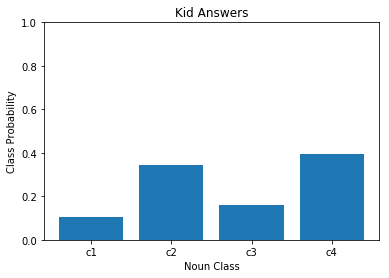

In [13]:
from data import kid_answers, SEMANTIC_FEMALE, BEG_PHON_R
from provided_functions import visualise_results

visualise_results(kid_answers, semantic_filter=[SEMANTIC_FEMALE], beg_phonological_filter=[BEG_PHON_R],
                  title="Kid Answers")

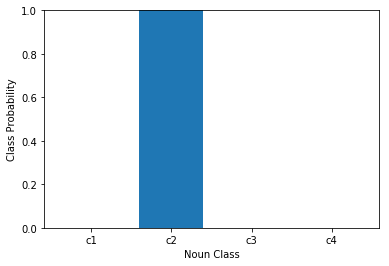

In [14]:
visualise_results(compute_trial_results_M0(), semantic_filter=[SEMANTIC_FEMALE], beg_phonological_filter=[BEG_PHON_R])

* c) The graphs do not match as it shows that c2 happens 100% of the time, while the kids answers is more uniform relative to the other graph. We can expect similar results in the paper, as Gagliardi et al point out, "The model’s classification differs from that of the children in that when features made conflicting predictions the model relied on the statistically strongest cue (the semantic feature), while the children did not rely so heavily on this." Indeed, their model had similar results, with one noun class cue probability being very close to 1.

### (d)

Model 3 in the paper investigated the Phonological Preference Hypothesis. Implement M3 according to the function definitions below, which implement equation (4) from Gagliardi et al. (Note: it will probably be easiest to modify your code from part b.)

Call `compute_trial_results_M3` with a beta of 0.65 (the best results from the paper) and print the result.

In [15]:
from data import features_by_trial, noun_class_probabilities, SEMANTIC_OTHER


def compute_trial_results_phon_only(beta):
    """
    Return an np.array of shape (n_trials, n_classes), where each row corresponds to
    a trial and each column corresponds to one of the four noun classes. The rows
    should be a probability distribution over the four noun classes for each trial
    using a Naive Bayes Classifier that looks at only phonological features
    (this computes the second term from formula (4) from Gagliardi et al.).
    """
    likelihood_terms = []
    beg_conditions = get_feature_given_class('beg_phonological')
    semantic_conditionals = get_feature_given_class('semantic')
    
    row = 0
    while row < len (features_by_trial['semantic']):
        denom = 0
        numerator = []
        beg_trial = features_by_trial['beg_phonological'][row]
        for column in range(len(noun_class_probabilities)):
            total_prob = beg_conditions[beg_trial][column] * noun_class_probabilities[column]
            numerator.append(total_prob)
            denom += total_prob
        for prob in range(len(numerator)):
            numerator[prob] = numerator[prob]/denom
        likelihood_terms.append(numerator)
        row += 1
    altered_with_beta = []
    for row in likelihood_terms:
        beta_row = []
        for column in row:
            beta_row.append(beta*column)
        altered_with_beta.append(beta_row)
    return np.array(altered_with_beta)


def compute_trial_results_M3(beta):
    """
    Return an np.array of shape (n_trials, n_classes), where each row corresponds to
    a trial and each column corresponds to one of the four noun classes. The rows
    should be a probability distribution over the four noun classes.
    
    The results should implement equation (4) from Gagliardi et al., using the beta
    parameter passed into the function.
    
    Hint: M3 is a mixture model, which you can implement as weighing the results of 
    two different models.
    """
    likelihood_terms = []
    second_eq = compute_trial_results_phon_only(beta)
    beg_conditions = get_feature_given_class('beg_phonological')
    semantic_conditionals = get_feature_given_class('semantic')

    row = 0
    while row < len (features_by_trial['semantic']):
        denom = 0
        numerator = []
        beg_trial = features_by_trial['beg_phonological'][row]
        semantic_trial = features_by_trial['semantic'][row]
        for column in range(len(noun_class_probabilities)):
            total_prob = beg_conditions[beg_trial][column] * semantic_conditionals[semantic_trial][column] * noun_class_probabilities[column]
            numerator.append(total_prob)
            denom += total_prob
        for prob in range(len(numerator)):
            numerator[prob] = numerator[prob]/denom
        likelihood_terms.append(numerator)
        row += 1
    
    altered_with_beta = []
    for row in range(len(likelihood_terms)):
        beta_row = []
        for column in range(len(likelihood_terms[row])):
            beta_row.append(((1-beta)*likelihood_terms[row][column])+second_eq[row][column])
        altered_with_beta.append(beta_row)
    return np.array(altered_with_beta)

M3_results = compute_trial_results_M3(0.65)

print(M3_results)

[[0.04729167 0.10168445 0.6264879  0.22453598]
 [0.0125275  0.03845124 0.41729603 0.53172523]
 [0.03415982 0.190967   0.49549478 0.2793784 ]
 [0.38415982 0.12489745 0.31688833 0.1740544 ]
 [0.03415982 0.47489745 0.31688833 0.1740544 ]
 [0.03415982 0.12489745 0.66688833 0.1740544 ]
 [0.39729167 0.0660499  0.39781208 0.13884636]
 [0.0125275  0.37568424 0.27281016 0.3389781 ]
 [0.0125275  0.02568424 0.62281016 0.3389781 ]
 [0.03415982 0.12489745 0.66688833 0.1740544 ]
 [0.03415982 0.190967   0.49549478 0.2793784 ]]


### (e)

Graph the results from M3 (using `visualise_results`) for the feature combination of semantic female and phonological initial *r*.

Is this a better fit than M0? Briefly explain what this comparison suggests about the way that children process noun classes in Tsez.  (Your answer should be no longer than 100 words.)

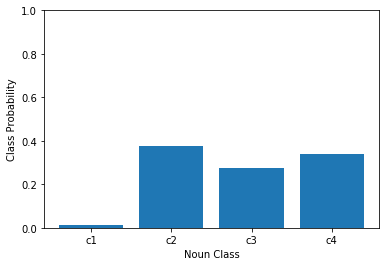

In [16]:
visualise_results(compute_trial_results_M3(0.65), semantic_filter=[SEMANTIC_FEMALE], beg_phonological_filter=[BEG_PHON_R])

* e) These graph results are a better fit than M0. In comparison with the Predicted Classification with Bias at 65% in Gagliardi et al paper, it matched their prediction. Children's processes of noun class in Tsez better fit the M3 model as it did with Gagliardi et al predicted model with bias. Therefore, I suggest that children's processes resemble that of a suboptimal performance (M3) rather than optimal performance (M0).

### (f)

Below, we've graphed the results for `young_kid_answers`, `older_kid_answers`, and `adult_answers`, for the combination of semantic female and phonological initial *r*.

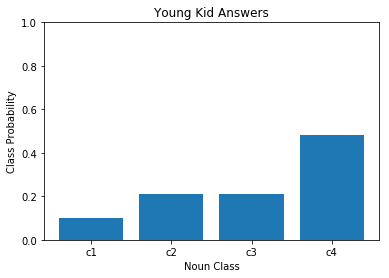

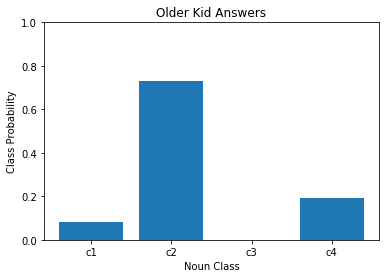

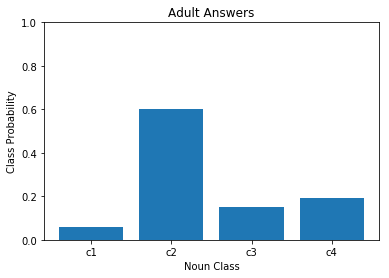

In [17]:
from data import young_kid_answers, older_kid_answers, adult_answers, SEMANTIC_FEMALE, BEG_PHON_R
from provided_functions import visualise_results

visualise_results(young_kid_answers, semantic_filter=[SEMANTIC_FEMALE], beg_phonological_filter=[BEG_PHON_R],
                  title="Young Kid Answers")
visualise_results(older_kid_answers, semantic_filter=[SEMANTIC_FEMALE], beg_phonological_filter=[BEG_PHON_R],
                  title="Older Kid Answers")
visualise_results(adult_answers, semantic_filter=[SEMANTIC_FEMALE], beg_phonological_filter=[BEG_PHON_R],
                  title="Adult Answers")

### (f, continued)

Complete the function `compute_optimal_M3_parameters` below to find the optimal parameter values for M3. 

Call `compute_optimal_M3_parameters` and print the optimal parameter values for each of `young_kid_answers`, `older_kid_answers`, and `adult_answers`.

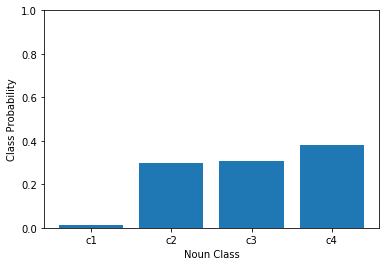

Sum Squared Error: 0.19560973987314106
Optimal for young_kid_answers: 0.7300


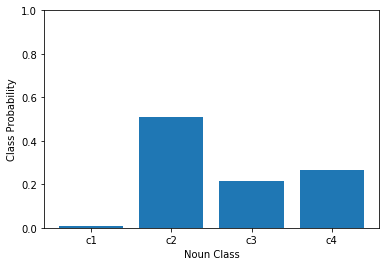

Sum Squared Error: 0.5871062669213173
Optimal for older_kid_answers: 0.5100


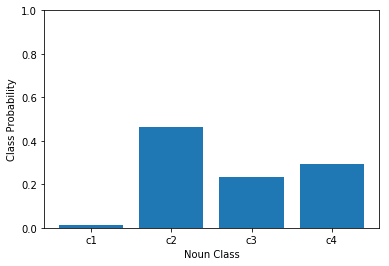

Sum Squared Error: 0.21670478438535618
Optimal for adult_answers: 0.5600


In [18]:
import numpy as np
from data import adult_answers, young_kid_answers, older_kid_answers
from provided_functions import sum_squared_error


def compute_optimal_M3_parameters(gold_standard):
    """
    gold_standard: np.array of shape (n_trials, n_classes) representing the trial answers
        from humans (this could be kid_answers, adult_answers, etc).

    Use a brute force approach to find the best parameters for M3 to fit the gold_standard.
    You should try all values from 0 to 1 (inclusive) by increments of 0.01 (i.e.
    [0, 0.01, 0.02, ... 1.00]).
    Find the M3 results using compute_trial_results_M3 from part d.
    Compute error between the model and gold_standard results using the sum_squared_error
    function in provided_functions.py.
    """
    RSS = sum_squared_error(compute_trial_results_M3(0), gold_standard)
    result_beta = 0
    for i in range (1,101):
        beta = i/100
        new_RSS = sum_squared_error(compute_trial_results_M3(beta), gold_standard)
        if new_RSS < RSS:
            RSS = new_RSS
            result_beta = beta
    visualise_results(compute_trial_results_M3(result_beta), semantic_filter=[SEMANTIC_FEMALE], beg_phonological_filter=[BEG_PHON_R])
    print ("Sum Squared Error: "+ str(RSS))
    return result_beta
                                
print("Optimal for young_kid_answers: {:.4f}".format(compute_optimal_M3_parameters(gold_standard=young_kid_answers)))
print("Optimal for older_kid_answers: {:.4f}".format(compute_optimal_M3_parameters(gold_standard=older_kid_answers)))
print("Optimal for adult_answers: {:.4f}".format(compute_optimal_M3_parameters(gold_standard=adult_answers)))

### (g)

Consider the various optimal parameter settings you found in part f, along with the three graphs of the human data we provided.

**1.** Do the optimal parameter settings you found fit your expectations given the developmental pattern of the human data?  Briefly explain why or why not.  (Your answer should be no longer than 100 words.)

**2.** What do the parameter settings and data suggest about the process of learning in children?  Relate what you found to ideas in the readings and discussed in class.  (Your answer should be no longer than 100 words.)  



g)
1. The optimal parameter settings found does fit my expectation. We can see that for each optimal parameter settings the sum squared error is relatively low for such predicted models, except for older kids. We can attribute this due to some 'overgeneralization', and it is indicative that the optimal beta parameter settings reflect such variances.

2. It is clear that the data suggests 'overgeneralization' and the 'U' learning curve that kids go through when they are learning classifiers. For young kids, the optimal paramter setting does reflect young kid answers, as Gagliardi et al points out "the best level value of beta ranged from .49 to .83"(p. 364), and then we can see that older kids over generalize noun class c2. Such phenomena is reflected in the data as the beta parameter overshoots to 0.51. However, such an optimal parameter still results in higher usage of the c3 noun class in the projected graph. Then, adults adjusts this overgeneralization as shown here where the beta increases from 0.51 (older kids) to .56. Such findings are consistent with the Traxler reading's mechanism of acquisition, but with respect to Gagliardi's interpretation of acquisition i.e. "intake vs. input". 